In [1]:
import pandas
import numpy as np
from matplotlib import pyplot as plt
import h5py

# from $ATS_SRC_DIR/tools/utils
import sys,os
try:
    sys.path.append(os.path.join(os.environ["ATS_SRC_DIR"],"tools","utils"))
except KeyError:
    sys.path.append("/Users/ecoon/research/arctic/ats/ats/repos/dev/tools/utils/")
#    pass
    
    
import plot_met
%matplotlib inline

In [2]:
# load the daymet data
df = pandas.read_csv("13868_lat65_lon-165_2017-02-02_052846.csv", header=6)
print df.keys()
d = np.array(df)
df.head()

Index([u'year', u'yday', u'dayl (s)', u'prcp (mm/day)', u'srad (W/m^2)',
       u'swe (kg/m^2)', u'tmax (deg c)', u'tmin (deg c)', u'vp (Pa)'],
      dtype='object')


,year,yday,dayl (s),prcp (mm/day),srad (W/m^2),swe (kg/m^2),tmax (deg c),tmin (deg c),vp (Pa)
0,1980,1,11750,0.0,0.0,60.0,-21.0,-27.5,80.0
1,1980,2,12096,0.0,0.0,60.0,-22.0,-28.5,40.0
2,1980,3,12096,0.0,0.0,60.0,-23.5,-29.5,40.0
3,1980,4,12442,3.0,0.0,60.0,-16.0,-30.5,40.0
4,1980,5,12787,4.0,0.0,64.0,-13.5,-17.5,160.0


In [3]:
# process to ATS units
P = df[u'prcp (mm/day)'] / 1000 / 86400.
Ta = (df[u'tmax (deg c)'] + df[u'tmin (deg c)'])/2.0 + 273.15

In [4]:
# load the data Elchin got
d = h5py.File("10yr-Nome_data.h5",'r')
d_time = d['time [s]'][:]/86400./365.0


In [47]:
print np.shape(Ta[20*365:])
print 20*365
print np.shape(d_time[:3285])
print np.shape(Ta[27*365:37*365])

(5840,)
7300
(3285,)
(3285,)


[  0.00000000e+00   2.73972603e-03   5.47945205e-03 ...,   9.99178082e+00
   9.99452055e+00   9.99726027e+00]
[-20.         -19.99726027 -19.99452055 ...,  15.99178082  15.99452055
  15.99726027]
(3650,)
diff: -2.43637747336


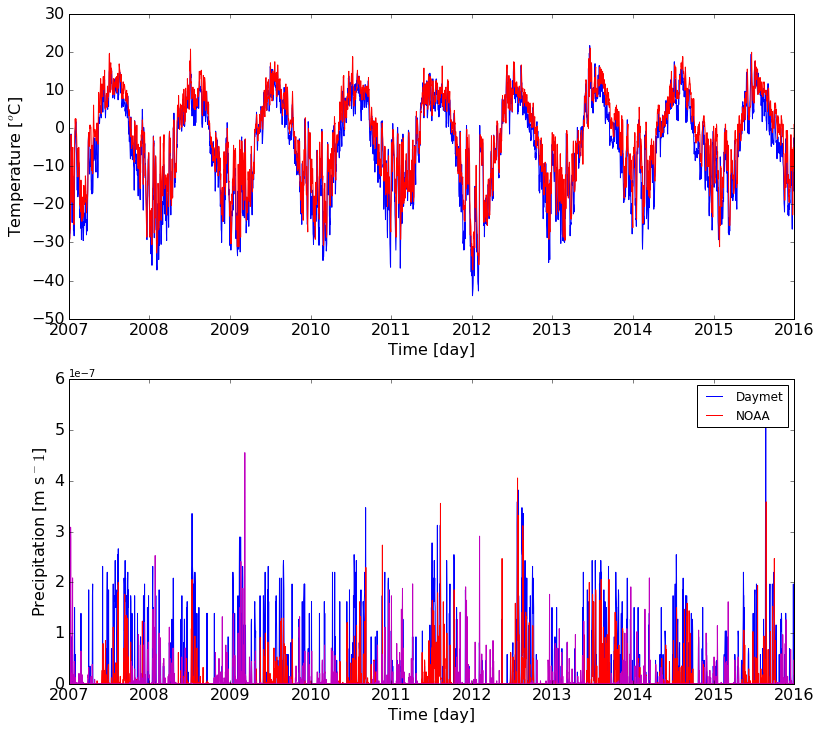

In [14]:
daymet_time = np.arange(0,len(P)) / 365. - 20.0
print d_time
print daymet_time
print np.shape(d_time)
fig = plt.figure();
fig.set_figheight(12); fig.set_figwidth(13);

plt.subplot(2,1,1)
#plt.plot(daymet_time[20*365:30*365], Ta[20*365:30*365]-273.15, 'b')
#plt.plot(d_time, d['air temperature [K]'][:]-273.15, 'r')
plt.plot(d_time[:3285], Ta[27*365:37*365]-273.15, 'b');
plt.plot(d_time,d['air temperature [K]'][:]-273.15, 'r');
plt.ylabel('Temperature [$^o$C]',fontsize=16);
plt.xlabel('Time [day]',fontsize=16);
plt.xlim([min(d_time),max(d_time[:3285])]);
plt.xticks(range(10),range(2007,2017),fontsize=16);
plt.yticks(fontsize=16);

plt.subplot(2,1,2);
plt.plot(d_time[:3285], P[27*365:37*365]);
plt.plot(d_time, d['precipitation rain [m s^-1]'], 'r');
plt.legend(['Daymet','NOAA']);
plt.plot(d_time, d['precipitation snow [m SWE s^-1]'], 'm');
plt.ylabel('Precipitation [m s$^-1$]',fontsize=16);
plt.xlabel('Time [day]',fontsize=16);
plt.xlim([min(d_time),max(d_time[:3285])]);
plt.xticks(range(10),range(2007,2017),fontsize=16);
plt.yticks(fontsize=16);
#plt.axes([-20,230,10,290])
diff=np.zeros(10)
for i in range(9):
    diff[i]=np.mean(Ta[(27+i)*365:(27+i+1)*365]-d['air temperature [K]'][i*365:(i+1)*365])
print 'diff:',np.mean(diff)

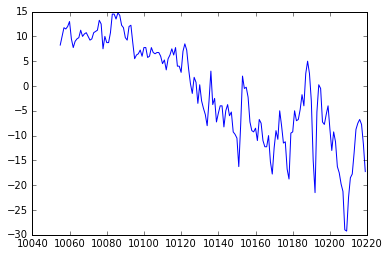

In [13]:
plt.plot( Ta[27*365+200:27*365+365]-273.15, 'b');

In [ ]:
daymet_time = np.arange(0,len(P)) / 365. - 20.0
fax = plt.subplots(2,1)

fax[1][0].plot(daymet_time, P)
fax[1][0].plot(d_time, d['precipitation rain [m s^-1]'][:], 'r')
fax[1][0].plot(d_time, d['precipitation snow [m SWE s^-1]'][:]/10.0, 'm')
fax[1][0].set_ylabel("precip [m/s]")


fax[1][1].plot(daymet_time, Ta, 'b')
fax[1][1].plot(d_time, d['air temperature [K]'][:], 'r')
fax[1][1].set_ylabel("temperature [K]")
fax[1][1].set_xlabel("days since Jan 1 2010")
#plt.axes([-20,230,10,290])



First we'll generate spinup files from this data.

In [ ]:
# spinup air temperature -- daily averages of the full dataset
fax = plt.subplots(2,1)

air_temp_raw = Ta.reshape((-1,365)).transpose()
for i in range(air_temp_raw.shape[1]):
    fax[1][0].plot(air_temp_raw[:,i])


air_temp = air_temp_raw.mean(axis=1)
fax[1][0].plot(air_temp,'k',linewidth=3)

import scipy.signal
air_temp_sm = scipy.signal.savgol_filter(air_temp, 61, 2, mode='wrap')
fax[1][1].plot(air_temp, 'k')
fax[1][1].plot(air_temp_sm, 'b')

plt.show()


In [ ]:
# spinup precip data -- annual means allocated based on air temp
ma_precip = P.mean()
print ma_precip
snow = np.where(air_temp_sm < 273.15, ma_precip, 0)
rain = np.where(air_temp_sm >= 273.15, ma_precip, 0)


In [ ]:
# spinup shortwave -- daily averages of the full dataset
fax = plt.subplots(2,1)

qSW = df[u'srad (W/m^2)']
qSW_raw = qSW.reshape((-1,365)).transpose()
for i in range(qSW_raw.shape[1]):
    fax[1][0].plot(qSW_raw[:,i])


qSW_m = qSW_raw.mean(axis=1)
fax[1][0].plot(qSW_m,'k',linewidth=3)

import scipy.signal
qSW_sm = scipy.signal.savgol_filter(qSW_m, 61, 2, mode='wrap')
fax[1][1].plot(qSW_m, 'k')
fax[1][1].plot(qSW_sm, 'b')

plt.show()


In [ ]:
# relative humidity via Buck equation (eg.) https://en.wikipedia.org/wiki/Vapour_pressure_of_water
Ta_c = Ta - 273.15
vp_sat = 611.21 * np.exp((18.678 - Ta_c/234.5)*(Ta_c/(257.14-Ta_c)))
rh = df['vp (Pa)']/vp_sat

ka0_ = 16.635764
ka_ = -6096.9385
kb_ = -2.7111933e-2
kc_ = 1.673952e-5
kd_ = 2.433502
vp_sat2 = 100.0*np.exp(ka0_ + ka_/Ta + (kb_ + kc_*Ta)*Ta + kd_*np.log(Ta))
rh2 = df['vp (Pa)']/vp_sat2

print df['vp (Pa)'].min(), df['vp (Pa)'].max()
print vp_sat.min(), vp_sat.max()
print vp_sat2.min(), vp_sat2.max()

print rh.min(), rh.max()
print rh2.min(), rh2.max()

#plt.plot(df['vp (Pa)'], 'k')
#plt.plot(vp_sat,'b')
#plt.plot(vp_sat2, 'r')
#plt.show()

# a few bad data points with 0 vapor pressure
RH = np.where(rh2 > 1, 1, np.where(rh2 <= 0, np.nan, rh2))
for i in range(len(RH)):
    if np.isnan(RH[i]):
        j = (j for j in range(i,len(RH)) if RH[j] > 0).next()
        RH[i] = RH[j]

# spinup RH -- daily averages of the full dataset
fax = plt.subplots(2,1)

RH_raw = RH.reshape((-1,365)).transpose()
for i in range(RH_raw.shape[1]):
    fax[1][0].plot(RH_raw[:,i])


RH_m = RH_raw.mean(axis=1)
fax[1][0].plot(RH_m,'k',linewidth=3)

import scipy.signal
RH_sm = scipy.signal.savgol_filter(RH_m, 61, 2, mode='wrap')
fax[1][1].plot(RH_m, 'k')
fax[1][1].plot(RH_sm, 'b')

plt.show()


In [ ]:
# organize data into 100 year cycle and save to file
time100 = np.arange(0, 86400.0*365*100, 86400.0)
air_temp100 = np.concatenate([air_temp_sm,]*100)
snow100 = np.concatenate([snow,]*100)
rain100 = np.concatenate([rain,]*100)
qSW100 = np.concatenate([qSW_sm,]*100)
rh100 = np.concatenate([RH_sm,]*100)
wind_speed100 = 8.5 * 0.44704 * np.ones(time100.shape,'d') # mean annual wind speed of 8.5 mi/hr is taken from other dataset

assert time100.shape == (36500,)
assert air_temp100.shape == (36500,)
assert snow100.shape == (36500,)
assert rain100.shape == (36500,)
assert qSW100.shape == (36500,)
assert rh100.shape == (36500,)
assert wind_speed100.shape == (36500,)

with h5py.File("spinup-100yr.h5",'w') as out:
    out.create_dataset("time [s]", data=time100)
    out.create_dataset("air temperature [K]", data=air_temp100)
    out.create_dataset("relative humidity [-]", data=rh100)
    out.create_dataset("precipitation rain [m s^-1]", data=rain100)
    out.create_dataset("precipitation snow [m SWE s^-1]", data=snow100)
    out.create_dataset("incoming shortwave radiation [W m^-2]", data=qSW100)
    out.create_dataset("wind speed [m s^-1]", data=wind_speed100)
    out.attrs.create("wind speed reference height [m]", data=0.0) # fix me

plot_met.plot_met("spinup-100yr.h5", end_time_in_years=1)
plt.show()

In [ ]:
# also just save the record
with h5py.File("Seward-DayMet-1985_2016.h5",'w') as out:
    out.create_dataset("time [s]", data=86400.0*np.array(range(36*365)))
    out.create_dataset("air temperature [K]", data=Ta)
    out.create_dataset("relative humidity [-]", data=RH)
    out.create_dataset("precipitation rain [m s^-1]", data=np.where(Ta >= 273.15, P, 0.0))
    out.create_dataset("precipitation snow [m SWE s^-1]", data=np.where(Ta < 273.15, P, 0.0))
    out.create_dataset("incoming shortwave radiation [W m^-2]", data=qSW)
    out.create_dataset("wind speed [m s^-1]", data=8.5*0.44704*np.ones(Ta.shape))
    out.attrs.create("wind speed reference height [m]", data=1.8) # fix me

plot_met.plot_met("Seward-DayMet-1985_2016.h5")
plt.show()